In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt

In [30]:
train = pd.read_csv("house-pi/dataset/dataset.csv")
test = pd.read_csv("house-pi/test.csv")
sample_submission = pd.read_csv("house-pi/sample_submission.csv")

In [31]:
target_col = "sale_price"
ID_col = "id"

In [32]:
train = train[train[target_col] < 1_500_000]  # outlier filtreleme

# Tarih dönüşümü
train["sale_date"] = pd.to_datetime(train["sale_date"])
test["sale_date"] = pd.to_datetime(test["sale_date"])
train["sale_year"] = train["sale_date"].dt.year
train["sale_month"] = train["sale_date"].dt.month
test["sale_year"] = test["sale_date"].dt.year
test["sale_month"] = test["sale_date"].dt.month

categorical_cols = [
    "city", "zoning", "subdivision", "present_use", "view_rainier", "view_olympics",
    "view_cascades", "view_territorial", "view_skyline", "view_sound", "view_lakewash",
    "view_lakesamm", "view_otherwater", "view_other", "submarket"
]

# Doldur ve encode et
for col in categorical_cols:
    if col in train.columns:
        train[col] = train[col].astype(str).fillna("missing")
        test[col] = test[col].astype(str).fillna("missing")

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])
test[categorical_cols] = encoder.transform(test[categorical_cols])

In [33]:
full_features = [
    "sale_year", "land_val", "imp_val", "latitude", "sqft",
    "longitude", "sqft_lot", "year_built", "join_year",
    "submarket", "area", "grade", "sale_month", "zoning", "sqft_1"
]

train_clean = train.dropna(subset=full_features + [target_col])
X = train_clean[full_features]
y = train_clean[target_col]
test_X = test[full_features]

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
def train_qr_model(alpha):
    model = lgb.LGBMRegressor(
        objective='quantile',
        alpha=alpha,
        learning_rate=0.01,  # düşürüldü
        n_estimators=1000,   # artırıldı
        min_child_samples=20,
        max_depth=7
    )
    model.fit(X_train, y_train)
    return model

In [36]:
model_lower = train_qr_model(0.1)
model_upper = train_qr_model(0.9)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 220000.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 929635.625000


In [37]:
pi_lower = model_lower.predict(test_X)
pi_upper = model_upper.predict(test_X)

In [38]:
def winkler_score(y_true, lower, upper, alpha=0.1):
    score = []
    for yt, l, u in zip(y_true, lower, upper):
        if l <= yt <= u:
            score.append(u - l)
        else:
            penalty = (2 / alpha) * (l - yt) if yt < l else (2 / alpha) * (yt - u)
            score.append((u - l) + penalty)
    return np.mean(score)

pred_lower_val = model_lower.predict(X_val)
pred_upper_val = model_upper.predict(X_val)
val_score = winkler_score(y_val, pred_lower_val, pred_upper_val)
print("📊 Validation Winkler Score:", val_score)

📊 Validation Winkler Score: 354368.6606634276


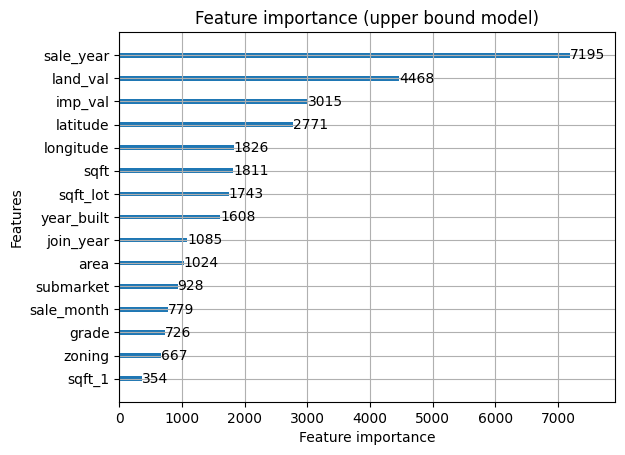

In [39]:
lgb.plot_importance(model_upper, max_num_features=20)
plt.title("Feature importance (upper bound model)")
plt.show()

In [40]:
submission = pd.DataFrame({
    "id": test[ID_col],
    "pi_lower": pi_lower,
    "pi_upper": pi_upper
})

submission.to_csv("submission.csv", index=False)
print("✅ Yeni submission dosyası oluşturuldu.")

✅ Yeni submission dosyası oluşturuldu.


In [41]:
# 📘 Grid Search: Parametre Taraması
param_grid = {
    'max_depth': [5, 7, 9],
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.03, 0.05]
}

best_score = float('inf')
best_params = None

for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            # Lower model
            model_lower = lgb.LGBMRegressor(
                objective='quantile',
                alpha=0.1,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_child_samples=20
            )
            model_lower.fit(X_train, y_train)
            pred_lower = model_lower.predict(X_val)

            # Upper model
            model_upper = lgb.LGBMRegressor(
                objective='quantile',
                alpha=0.9,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_child_samples=20
            )
            model_upper.fit(X_train, y_train)
            pred_upper = model_upper.predict(X_val)

            score = winkler_score(y_val, pred_lower, pred_upper)

            print(f"[max_depth={max_depth}, n_estimators={n_estimators}, lr={learning_rate}] => Winkler: {score:.2f}")
            if score < best_score:
                best_score = score
                best_params = {
                    'max_depth': max_depth,
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate
                }

print("\n🔍 Best Winkler Score:", best_score)
print("🏆 Best Parameters:", best_params)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 220000.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 929635.625000
[max_depth=5, n_estimators=200, lr=0.01] => Winkler: 534263.57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in th

In [43]:
# 📘 Cell 12: Final quantile modelleri (tuned parametrelerle)
def train_final_qr(alpha):
    model = lgb.LGBMRegressor(
        objective='quantile',
        alpha=alpha,
        learning_rate=0.05,
        n_estimators=400,
        max_depth=7,
        min_child_samples=20
    )
    model.fit(X, y)  # Tüm veride eğitiyoruz
    return model

final_model_lower = train_final_qr(0.1)
final_model_upper = train_final_qr(0.9)

pi_lower_final = final_model_lower.predict(test_X)
pi_upper_final = final_model_upper.predict(test_X)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2264
[LightGBM] [Info] Number of data points in the train set: 191049, number of used features: 15
[LightGBM] [Info] Start training from score 220000.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2264
[LightGBM] [Info] Number of data points in the train set: 191049, number of used features: 15
[LightGBM] [Info] Start training from score 930000.000000


In [44]:
# 📘 Cell 13: Tuned submission dosyası
submission = pd.DataFrame({
    "id": test[ID_col],
    "pi_lower": pi_lower_final,
    "pi_upper": pi_upper_final
})
submission.to_csv("submission_tuned.csv", index=False)
print("✅ Tuned model ile submission dosyası oluşturuldu.")


✅ Tuned model ile submission dosyası oluşturuldu.


In [49]:
# 📘 LightGBM Quantile Model Trainer
def train_qr_model(alpha, params):
    model = lgb.LGBMRegressor(
        objective='quantile',
        alpha=alpha,
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_child_samples=20,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

# 📘 Ensemble + Winkler evaluator
def evaluate_ensemble(params):
    model_lower = train_qr_model(0.1, params)
    model_upper = train_qr_model(0.9, params)
    pred_lower = model_lower.predict(X_val)
    pred_upper = model_upper.predict(X_val)
    score = winkler_score(y_val, pred_lower, pred_upper)
    return score

# 📘 Denenecek yapılandırmalar
configs = [
    {"learning_rate": 0.03, "n_estimators": 400, "max_depth": 7},
    {"learning_rate": 0.03, "n_estimators": 500, "max_depth": 7},
    {"learning_rate": 0.03, "n_estimators": 600, "max_depth": 7}
]

# 📘 Test loop
for cfg in configs:
    score = evaluate_ensemble(cfg)
    print(f"[n_estimators={cfg['n_estimators']}, lr={cfg['learning_rate']}] => Winkler: {score:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 220000.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 929635.625000
[n_estimators=400, lr=0.03] => Winkler: 348915.28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins